# **Model Training**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print(f"{'torch:':<20} {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'device:':<20} {device}")

import numpy as np
import math
import random
print(f"{'numpy:':<20} {np.__version__}")

import matplotlib.pyplot as plt
print(f"{'matplotlib:':<20} {plt.matplotlib.__version__}")

from tqdm import tqdm

import logger
print(f"{'logger (custom):':<20} loaded")

from Models.Architectures.edgeGNN import EdgeCentricNetwork
from DataManagement.data import financialDataset

torch:               2.7.1+cu118
device:              cuda
numpy:               2.2.4
matplotlib:          3.10.3
logger (custom):     loaded


In [2]:
dataset = financialDataset()

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1254 rows with data
XLF: 1254 rows with data
XLE: 1254 rows with data
XLV: 1254 rows with data
XLI: 1254 rows with data
XLP: 1254 rows with data
XLY: 1254 rows with data
XLU: 1254 rows with data
XLB: 1254 rows with data
XLRE: 1254 rows with data
XLC: 1254 rows with data
✓ All sectors have same number of dates
Common dates: 1254
XLK len: 1254
XLF len: 1254
XLE len: 1254
XLV len: 1254
XLI len: 1254
XLP len: 1254
XLY len: 1254
XLU len: 1254
XLB len: 1254
XLRE len: 1254
XLC len: 12

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  feature_data = torch.tensor(data=feature_data, dtype=torch.float32).transpose(0, 1)


In [ ]:
num_samples = len(dataset)

train_split = 0.8
test_split = 0.2

train_size = int(train_split * num_samples)
test_size = num_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size, num_samples)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

sample_batch = next(iter(train_loader))
print(f"Batch Feature Dim: {sample_batch[0].shape}")
print(f"Batch Target Dim: {sample_batch[1].shape}")
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Batch Feature Dim: torch.Size([32, 11, 89])
Batch Target Dim: torch.Size([32, 11])
Train Dataset Length: 978
Test Dataset Length: 245


In [4]:
model = EdgeCentricNetwork(num_nodes=dataset.num_sectors, directed=True, edge_dim=10, node_dim=dataset.features.shape[2])
model.to(device)
model

EdgeCentricNetwork(
  (edge_updater): Sequential(
    (0): Linear(in_features=178, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (regression): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
LR = 4e-5
optimizer = optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

In [ ]:
epoch_num = 2000

epoch_losses = []
batch_losses = []

model.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epoch_num}]", leave=False)

    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.unsqueeze(2).to(device)

        optimizer.zero_grad()

        output = model(features)

        loss = criterion(output, targets)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{epoch_num}] Loss: {epoch_losses[-1]:.6f}")

Epoch [1/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.9]

Epoch [1/500] Loss: 34.989428


Epoch [2/500] Loss: 44.560892


Epoch [3/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=24.5]

Epoch [3/500] Loss: 52.786931


Epoch [4/500] Loss: 32.577761


Epoch [5/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=19.4]

Epoch [5/500] Loss: 43.999242


Epoch [6/500] Loss: 32.972245


Epoch [7/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.4]

Epoch [7/500] Loss: 40.328523


Epoch [8/500] Loss: 137.917034


Epoch [9/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=122]

Epoch [9/500] Loss: 311.346727


Epoch [10/500] Loss: 197.645924


Epoch [11/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=459]    

Epoch [11/500] Loss: 349.792746


Epoch [12/500] Loss: 513.933714


Epoch [13/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=247]   

Epoch [13/500] Loss: 343.032490


Epoch [14/500] Loss: 190.370159


Epoch [15/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=70.9]

Epoch [15/500] Loss: 72.592363


Epoch [16/500] Loss: 46.696337


Epoch [17/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=38]  

Epoch [17/500] Loss: 46.456793


Epoch [18/500] Loss: 31.808367


Epoch [19/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.7]

Epoch [19/500] Loss: 29.246887


Epoch [20/500] Loss: 27.691489


Epoch [21/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.5]

Epoch [21/500] Loss: 36.491554


Epoch [22/500] Loss: 29.213009


Epoch [23/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.6]

Epoch [23/500] Loss: 40.768701


Epoch [24/500] Loss: 33.558321


Epoch [25/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=39.3]

Epoch [25/500] Loss: 43.608763


Epoch [26/500] Loss: 38.102490


Epoch [27/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.6]

Epoch [27/500] Loss: 29.440997


Epoch [28/500] Loss: 26.703271


Epoch [29/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.4]

Epoch [29/500] Loss: 23.352371


Epoch [30/500] Loss: 27.134178


Epoch [31/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=19.6]

Epoch [31/500] Loss: 22.039930


Epoch [32/500] Loss: 28.142871


Epoch [33/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12]  

Epoch [33/500] Loss: 27.311889


Epoch [34/500] Loss: 24.786891


Epoch [35/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=11.3]

Epoch [35/500] Loss: 23.703606


Epoch [36/500] Loss: 25.682339


Epoch [37/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.6]

Epoch [37/500] Loss: 27.241355


Epoch [38/500] Loss: 31.093919


Epoch [39/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=19.4]

Epoch [39/500] Loss: 39.986182


Epoch [40/500] Loss: 45.885208


Epoch [41/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=23]  

Epoch [41/500] Loss: 41.598384


Epoch [42/500] Loss: 31.131090


Epoch [43/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.8]

Epoch [43/500] Loss: 25.353101


Epoch [44/500] Loss: 35.348388


Epoch [45/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=72.7]

Epoch [45/500] Loss: 97.557342


Epoch [46/500] Loss: 147.605129


Epoch [47/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=67.1]

Epoch [47/500] Loss: 117.465995


Epoch [48/500] Loss: 59.038052


Epoch [49/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=96.7]

Epoch [49/500] Loss: 52.477806


Epoch [50/500] Loss: 73.495913


Epoch [51/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=27.1]

Epoch [51/500] Loss: 54.913845


Epoch [52/500] Loss: 111.046914


Epoch [53/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.03e+3]

Epoch [53/500] Loss: 627.223857


Epoch [54/500] Loss: 1160.467638


Epoch [55/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=517]    

Epoch [55/500] Loss: 1142.661330


Epoch [56/500] Loss: 447.144304


Epoch [57/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=56.5]

Epoch [57/500] Loss: 200.770694


Epoch [58/500] Loss: 83.134594


Epoch [59/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=37.4]

Epoch [59/500] Loss: 46.145470


Epoch [60/500] Loss: 60.556092


Epoch [61/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=19.5]

Epoch [61/500] Loss: 43.696642


Epoch [62/500] Loss: 33.150395


Epoch [63/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=18.4]

Epoch [63/500] Loss: 31.030215


Epoch [64/500] Loss: 30.951923


Epoch [65/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.3]

Epoch [65/500] Loss: 25.625738


Epoch [66/500] Loss: 23.234332


Epoch [67/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.9]

Epoch [67/500] Loss: 18.542578


Epoch [68/500] Loss: 20.526273


Epoch [69/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.1]

Epoch [69/500] Loss: 18.346298


Epoch [70/500] Loss: 19.860344


Epoch [71/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.9]

Epoch [71/500] Loss: 19.538798


Epoch [72/500] Loss: 25.256833


Epoch [73/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.79]

Epoch [73/500] Loss: 21.927456


Epoch [74/500] Loss: 18.112426


Epoch [75/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.4]

Epoch [75/500] Loss: 22.253108


Epoch [76/500] Loss: 28.846624


Epoch [77/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=15.4]

Epoch [77/500] Loss: 31.934156


Epoch [78/500] Loss: 20.236115


Epoch [79/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=16.8]

Epoch [79/500] Loss: 18.940630


Epoch [80/500] Loss: 22.886098


Epoch [81/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.9]

Epoch [81/500] Loss: 27.091545


Epoch [82/500] Loss: 20.869806


Epoch [83/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.3]

Epoch [83/500] Loss: 23.573433


Epoch [84/500] Loss: 17.267513


Epoch [85/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.56]

Epoch [85/500] Loss: 14.847210


Epoch [86/500] Loss: 26.964757


Epoch [87/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.7]

Epoch [87/500] Loss: 26.655066


Epoch [88/500] Loss: 22.080714


Epoch [89/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.8]

Epoch [89/500] Loss: 22.910884


Epoch [90/500] Loss: 20.793784


Epoch [91/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.9]

Epoch [91/500] Loss: 24.814820


Epoch [92/500] Loss: 44.624305


Epoch [93/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=70.6]

Epoch [93/500] Loss: 80.095654


Epoch [94/500] Loss: 85.544219


Epoch [95/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14.3]

Epoch [95/500] Loss: 37.175728


Epoch [96/500] Loss: 20.873965


Epoch [97/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.83]

Epoch [97/500] Loss: 15.096340


Epoch [98/500] Loss: 22.512419


Epoch [99/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14.4]

Epoch [99/500] Loss: 31.343271


Epoch [100/500] Loss: 509.054131


Epoch [101/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=436]    

Epoch [101/500] Loss: 1177.445725


Epoch [102/500] Loss: 130.123293


Epoch [103/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=134] 

Epoch [103/500] Loss: 163.225439


Epoch [104/500] Loss: 76.273195


Epoch [105/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=41.1]

Epoch [105/500] Loss: 78.182589


Epoch [106/500] Loss: 34.830249


Epoch [107/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.3]

Epoch [107/500] Loss: 21.643827


Epoch [108/500] Loss: 24.648823


Epoch [109/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.67]

Epoch [109/500] Loss: 19.867749


Epoch [110/500] Loss: 20.370903


Epoch [111/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.2]

Epoch [111/500] Loss: 16.528288


Epoch [112/500] Loss: 16.124568


Epoch [113/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=16.3]

Epoch [113/500] Loss: 15.354250


Epoch [114/500] Loss: 13.743745


Epoch [115/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.89]

Epoch [115/500] Loss: 12.296080


Epoch [116/500] Loss: 11.298936


Epoch [117/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.86]

Epoch [117/500] Loss: 12.325156


Epoch [118/500] Loss: 12.162373


Epoch [119/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.48]

Epoch [119/500] Loss: 13.394145


Epoch [120/500] Loss: 14.079966


Epoch [121/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.24]

Epoch [121/500] Loss: 12.996661


Epoch [122/500] Loss: 11.310736


Epoch [123/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.35]

Epoch [123/500] Loss: 11.996757


Epoch [124/500] Loss: 10.255124


Epoch [125/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.38]

Epoch [125/500] Loss: 10.771770


Epoch [126/500] Loss: 21.525484


Epoch [127/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=54]  

Epoch [127/500] Loss: 84.433504


Epoch [128/500] Loss: 117.838630


Epoch [129/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=114] 

Epoch [129/500] Loss: 97.374385


Epoch [130/500] Loss: 98.651020


Epoch [131/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=30.4]

Epoch [131/500] Loss: 46.442258


Epoch [132/500] Loss: 39.842807


Epoch [133/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=27.1]

Epoch [133/500] Loss: 41.622142


Epoch [134/500] Loss: 72.356732


Epoch [135/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14]  

Epoch [135/500] Loss: 42.014838


Epoch [136/500] Loss: 23.580395


Epoch [137/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=23.3]

Epoch [137/500] Loss: 24.307600


Epoch [138/500] Loss: 18.696411


Epoch [139/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.02]

Epoch [139/500] Loss: 14.943783


Epoch [140/500] Loss: 18.311218


Epoch [141/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=27.4]

Epoch [141/500] Loss: 41.454453


Epoch [142/500] Loss: 90.753331


Epoch [143/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=30.9]

Epoch [143/500] Loss: 145.711096


Epoch [144/500] Loss: 103.740956


Epoch [145/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=90]  

Epoch [145/500] Loss: 66.854093


Epoch [146/500] Loss: 100.057816


Epoch [147/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=16.3]

Epoch [147/500] Loss: 60.496855


Epoch [148/500] Loss: 60.450926


Epoch [149/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=36.9]

Epoch [149/500] Loss: 106.049718


Epoch [150/500] Loss: 72.444051


Epoch [151/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=37.7]

Epoch [151/500] Loss: 79.835646


Epoch [152/500] Loss: 36.792996


Epoch [153/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.2]

Epoch [153/500] Loss: 19.934003


Epoch [154/500] Loss: 23.042144


Epoch [155/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.26]

Epoch [155/500] Loss: 18.296382


Epoch [156/500] Loss: 12.106710


Epoch [157/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.78]

Epoch [157/500] Loss: 13.379492


Epoch [158/500] Loss: 12.833876


Epoch [159/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.51]

Epoch [159/500] Loss: 11.630298


Epoch [160/500] Loss: 29.475922


Epoch [161/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=39.8]

Epoch [161/500] Loss: 39.685752


Epoch [162/500] Loss: 23.281667


Epoch [163/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.36]

Epoch [163/500] Loss: 11.974177


Epoch [164/500] Loss: 19.591349


Epoch [165/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.8]

Epoch [165/500] Loss: 22.312547


Epoch [166/500] Loss: 50.302840


Epoch [167/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.5]

Epoch [167/500] Loss: 91.044052


Epoch [168/500] Loss: 188.871425


Epoch [169/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=69.4]

Epoch [169/500] Loss: 275.330255


Epoch [170/500] Loss: 95.578107


Epoch [171/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=19.1]

Epoch [171/500] Loss: 51.287956


Epoch [172/500] Loss: 30.035521


Epoch [173/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.48]

Epoch [173/500] Loss: 16.218890


Epoch [174/500] Loss: 22.706077


Epoch [175/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.61]

Epoch [175/500] Loss: 23.294717


Epoch [176/500] Loss: 32.432074


Epoch [177/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.64]

Epoch [177/500] Loss: 12.624400


Epoch [178/500] Loss: 22.483725


Epoch [179/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=30.2]

Epoch [179/500] Loss: 29.928905


Epoch [180/500] Loss: 32.599656


Epoch [181/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.8]

Epoch [181/500] Loss: 33.858606


Epoch [182/500] Loss: 23.574323


Epoch [183/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.97]

Epoch [183/500] Loss: 14.315189


Epoch [184/500] Loss: 18.479395


Epoch [185/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12]  

Epoch [185/500] Loss: 28.275484


Epoch [186/500] Loss: 27.126726


Epoch [187/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.89]

Epoch [187/500] Loss: 16.951394


Epoch [188/500] Loss: 16.167541


Epoch [189/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.3]

Epoch [189/500] Loss: 15.828160


Epoch [190/500] Loss: 13.863579


Epoch [191/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.77]

Epoch [191/500] Loss: 9.381476


Epoch [192/500] Loss: 7.815690


Epoch [193/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.29]

Epoch [193/500] Loss: 9.535504


Epoch [194/500] Loss: 21.633229


Epoch [195/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=29.9]

Epoch [195/500] Loss: 38.287444


Epoch [196/500] Loss: 34.247854


Epoch [197/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.3]

Epoch [197/500] Loss: 26.998136


Epoch [198/500] Loss: 115.942082


Epoch [199/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.18e+3]

Epoch [199/500] Loss: 2069.174720


Epoch [200/500] Loss: 1828.258314


Epoch [201/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=467]

Epoch [201/500] Loss: 422.482953


Epoch [202/500] Loss: 271.239453


Epoch [203/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=176] 

Epoch [203/500] Loss: 144.919719


Epoch [204/500] Loss: 143.500595


Epoch [205/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.4]

Epoch [205/500] Loss: 60.249088


Epoch [206/500] Loss: 57.239565


Epoch [207/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=32.3]

Epoch [207/500] Loss: 39.101080


Epoch [208/500] Loss: 29.811760


Epoch [209/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=55.5]

Epoch [209/500] Loss: 36.908269


Epoch [210/500] Loss: 23.338969


Epoch [211/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.07]

Epoch [211/500] Loss: 17.719531


Epoch [212/500] Loss: 14.017674


Epoch [213/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=22]  

Epoch [213/500] Loss: 19.889626


Epoch [214/500] Loss: 21.354866


Epoch [215/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=23]  

Epoch [215/500] Loss: 18.804835


Epoch [216/500] Loss: 11.221255


Epoch [217/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.99]

Epoch [217/500] Loss: 8.085295


Epoch [218/500] Loss: 8.450739


Epoch [219/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.84]

Epoch [219/500] Loss: 13.327709


Epoch [220/500] Loss: 9.712453


Epoch [221/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.43]

Epoch [221/500] Loss: 8.250144


Epoch [222/500] Loss: 6.441553


Epoch [223/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.19]

Epoch [223/500] Loss: 12.170391


Epoch [224/500] Loss: 7.208270


Epoch [225/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.55]

Epoch [225/500] Loss: 6.617370


Epoch [226/500] Loss: 7.722816


Epoch [227/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.34]

Epoch [227/500] Loss: 8.213140


Epoch [228/500] Loss: 7.483269


Epoch [229/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.3] 

Epoch [229/500] Loss: 9.999038


Epoch [230/500] Loss: 9.290370


Epoch [231/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.21]

Epoch [231/500] Loss: 9.873481


Epoch [232/500] Loss: 7.254013


Epoch [233/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.21]

Epoch [233/500] Loss: 7.818513


Epoch [234/500] Loss: 8.458947


Epoch [235/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.97]

Epoch [235/500] Loss: 6.855929


Epoch [236/500] Loss: 7.689210


Epoch [237/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.95]

Epoch [237/500] Loss: 10.745824


Epoch [238/500] Loss: 12.861048


Epoch [239/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.59]

Epoch [239/500] Loss: 14.304662


Epoch [240/500] Loss: 24.558598


Epoch [241/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=11.6]

Epoch [241/500] Loss: 25.115316


Epoch [242/500] Loss: 16.468634


Epoch [243/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.12]

Epoch [243/500] Loss: 9.417576


Epoch [244/500] Loss: 14.771611


Epoch [245/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.9]

Epoch [245/500] Loss: 23.156841


Epoch [246/500] Loss: 26.453602


Epoch [247/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=15.5]

Epoch [247/500] Loss: 31.086616


Epoch [248/500] Loss: 18.268598


Epoch [249/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.61]

Epoch [249/500] Loss: 15.518005


Epoch [250/500] Loss: 15.242624


Epoch [251/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.43]

Epoch [251/500] Loss: 14.630133


Epoch [252/500] Loss: 19.747006


Epoch [253/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.11]

Epoch [253/500] Loss: 16.889844


Epoch [254/500] Loss: 10.515543


Epoch [255/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.5]

Epoch [255/500] Loss: 11.462038


Epoch [256/500] Loss: 9.021234


Epoch [257/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.59]

Epoch [257/500] Loss: 8.100220


Epoch [258/500] Loss: 6.279150


Epoch [259/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.93]

Epoch [259/500] Loss: 9.861798


Epoch [260/500] Loss: 23.181338


Epoch [261/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.1]

Epoch [261/500] Loss: 32.276846


Epoch [262/500] Loss: 31.521382


Epoch [263/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=69]  

Epoch [263/500] Loss: 87.826769


Epoch [264/500] Loss: 205.675691


Epoch [265/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=60.3]

Epoch [265/500] Loss: 171.560333


Epoch [266/500] Loss: 129.807531


Epoch [267/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=74]  

Epoch [267/500] Loss: 107.724809


Epoch [268/500] Loss: 44.405306


Epoch [269/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=50.7]

Epoch [269/500] Loss: 49.176791


Epoch [270/500] Loss: 33.342882


Epoch [271/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=13.9]

Epoch [271/500] Loss: 37.981821


Epoch [272/500] Loss: 28.477265


Epoch [273/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.52]

Epoch [273/500] Loss: 35.759490


Epoch [274/500] Loss: 22.363971


Epoch [275/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.26]

Epoch [275/500] Loss: 13.112868


Epoch [276/500] Loss: 9.680355


Epoch [277/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.34]

Epoch [277/500] Loss: 9.694772


Epoch [278/500] Loss: 12.095012


Epoch [279/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.6] 

Epoch [279/500] Loss: 13.431935


Epoch [280/500] Loss: 20.173079


Epoch [281/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.22]

Epoch [281/500] Loss: 13.566549


Epoch [282/500] Loss: 9.762344


Epoch [283/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.42]

Epoch [283/500] Loss: 11.514752


Epoch [284/500] Loss: 13.837190


Epoch [285/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.53]

Epoch [285/500] Loss: 13.304574


Epoch [286/500] Loss: 11.803154


Epoch [287/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.7]

Epoch [287/500] Loss: 17.292680


Epoch [288/500] Loss: 25.561216


Epoch [289/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=15.5]

Epoch [289/500] Loss: 23.952873


Epoch [290/500] Loss: 16.729134


Epoch [291/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.24]

Epoch [291/500] Loss: 19.668877


Epoch [292/500] Loss: 87.784678


Epoch [293/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=93.8]   

Epoch [293/500] Loss: 592.818122


Epoch [294/500] Loss: 312.366712


Epoch [295/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=47.2]

Epoch [295/500] Loss: 146.788900


Epoch [296/500] Loss: 81.243690


Epoch [297/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.8]

Epoch [297/500] Loss: 28.373204


Epoch [298/500] Loss: 28.541091


Epoch [299/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14.3]

Epoch [299/500] Loss: 24.373686


Epoch [300/500] Loss: 36.581848


Epoch [301/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.19]

Epoch [301/500] Loss: 19.688783


Epoch [302/500] Loss: 14.560664


Epoch [303/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.86]

Epoch [303/500] Loss: 7.962914


Epoch [304/500] Loss: 8.057580


Epoch [305/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.2]

Epoch [305/500] Loss: 10.235180


Epoch [306/500] Loss: 13.778561


Epoch [307/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=16]  

Epoch [307/500] Loss: 12.444547


Epoch [308/500] Loss: 9.123990


Epoch [309/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.38]

Epoch [309/500] Loss: 6.647453


Epoch [310/500] Loss: 4.416830


Epoch [311/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.49]

Epoch [311/500] Loss: 9.213570


Epoch [312/500] Loss: 20.927918


Epoch [313/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.1]

Epoch [313/500] Loss: 54.011872


Epoch [314/500] Loss: 36.465694


Epoch [315/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.83]

Epoch [315/500] Loss: 26.357241


Epoch [316/500] Loss: 38.138026


Epoch [317/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=178] 

Epoch [317/500] Loss: 111.608298


Epoch [318/500] Loss: 233.968221


Epoch [319/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=176] 

Epoch [319/500] Loss: 174.427683


Epoch [320/500] Loss: 63.208847


Epoch [321/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=18.8]

Epoch [321/500] Loss: 54.650266


Epoch [322/500] Loss: 26.122411


Epoch [323/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.93]

Epoch [323/500] Loss: 14.912548


Epoch [324/500] Loss: 13.984125


Epoch [325/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21.4]

Epoch [325/500] Loss: 13.617352


Epoch [326/500] Loss: 8.129547


Epoch [327/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.29]

Epoch [327/500] Loss: 9.448305


Epoch [328/500] Loss: 10.417610


Epoch [329/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.24]

Epoch [329/500] Loss: 5.632014


Epoch [330/500] Loss: 7.808361


Epoch [331/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.16]

Epoch [331/500] Loss: 6.782604


Epoch [332/500] Loss: 6.498035


Epoch [333/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.85]

Epoch [333/500] Loss: 5.988922


Epoch [334/500] Loss: 3.884210


Epoch [335/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.94]

Epoch [335/500] Loss: 4.479025


Epoch [336/500] Loss: 5.787914


Epoch [337/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.26]

Epoch [337/500] Loss: 6.392657


Epoch [338/500] Loss: 7.170594


Epoch [339/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.19]

Epoch [339/500] Loss: 10.048372


Epoch [340/500] Loss: 10.190024


Epoch [341/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=29.3]

Epoch [341/500] Loss: 23.071342


Epoch [342/500] Loss: 61.457122


Epoch [343/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=21]  

Epoch [343/500] Loss: 30.999212


Epoch [344/500] Loss: 20.585302


Epoch [345/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=31.8]

Epoch [345/500] Loss: 37.602017


Epoch [346/500] Loss: 46.353186


Epoch [347/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=68.5]

Epoch [347/500] Loss: 57.172894


Epoch [348/500] Loss: 449.580252


Epoch [349/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=328]    

Epoch [349/500] Loss: 1210.222941


Epoch [350/500] Loss: 558.836872


Epoch [351/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=128] 

Epoch [351/500] Loss: 111.709271


Epoch [352/500] Loss: 138.815200


Epoch [353/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=16.7]

Epoch [353/500] Loss: 53.317167


Epoch [354/500] Loss: 42.835976


Epoch [355/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=30]  

Epoch [355/500] Loss: 33.381870


Epoch [356/500] Loss: 21.335725


Epoch [357/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.14]

Epoch [357/500] Loss: 12.811720


Epoch [358/500] Loss: 14.670779


Epoch [359/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.7] 

Epoch [359/500] Loss: 9.789473


Epoch [360/500] Loss: 6.172440


Epoch [361/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.61]

Epoch [361/500] Loss: 4.839115


Epoch [362/500] Loss: 4.737039


Epoch [363/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.23]

Epoch [363/500] Loss: 9.746348


Epoch [364/500] Loss: 6.052276


Epoch [365/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.89]

Epoch [365/500] Loss: 7.723733


Epoch [366/500] Loss: 4.327440


Epoch [367/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.01]

Epoch [367/500] Loss: 6.504927


Epoch [368/500] Loss: 5.239301


Epoch [369/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.5] 

Epoch [369/500] Loss: 4.108567


Epoch [370/500] Loss: 4.881852


Epoch [371/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.33]

Epoch [371/500] Loss: 4.444953


Epoch [372/500] Loss: 3.135613


Epoch [373/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=8.71]

Epoch [373/500] Loss: 3.944326


Epoch [374/500] Loss: 3.952450


Epoch [375/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.09]

Epoch [375/500] Loss: 4.052802


Epoch [376/500] Loss: 4.358426


Epoch [377/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.73]

Epoch [377/500] Loss: 4.458889


Epoch [378/500] Loss: 3.387991


Epoch [379/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.72]

Epoch [379/500] Loss: 3.291478


Epoch [380/500] Loss: 3.038461


Epoch [381/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.12]

Epoch [381/500] Loss: 5.692644


Epoch [382/500] Loss: 7.268427


Epoch [383/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.79]

Epoch [383/500] Loss: 4.934228


Epoch [384/500] Loss: 3.629821


Epoch [385/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.02]

Epoch [385/500] Loss: 5.557929


Epoch [386/500] Loss: 7.195659


Epoch [387/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.13]

Epoch [387/500] Loss: 11.155750


Epoch [388/500] Loss: 19.600722


Epoch [389/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.19]

Epoch [389/500] Loss: 7.923829


Epoch [390/500] Loss: 8.808242


Epoch [391/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.02]

Epoch [391/500] Loss: 5.998004


Epoch [392/500] Loss: 3.842212


Epoch [393/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.27]

Epoch [393/500] Loss: 2.777356


Epoch [394/500] Loss: 3.216461


Epoch [395/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.7] 

Epoch [395/500] Loss: 5.496374


Epoch [396/500] Loss: 10.520334


Epoch [397/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=37.9]

Epoch [397/500] Loss: 42.682517


Epoch [398/500] Loss: 44.818696


Epoch [399/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=26.5]

Epoch [399/500] Loss: 43.790381


Epoch [400/500] Loss: 43.953846


Epoch [401/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=12.4]

Epoch [401/500] Loss: 32.296969


Epoch [402/500] Loss: 56.174038


Epoch [403/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14.7]

Epoch [403/500] Loss: 67.017027


Epoch [404/500] Loss: 59.821456


Epoch [405/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=14.4]

Epoch [405/500] Loss: 63.209739


Epoch [406/500] Loss: 21.921037


Epoch [407/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.33]

Epoch [407/500] Loss: 10.740336


Epoch [408/500] Loss: 13.528980


Epoch [409/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=15.4]

Epoch [409/500] Loss: 27.657938


Epoch [410/500] Loss: 33.632258


Epoch [411/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=139] 

Epoch [411/500] Loss: 114.036955


Epoch [412/500] Loss: 214.259468


Epoch [413/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=51.8]

Epoch [413/500] Loss: 117.720190


Epoch [414/500] Loss: 74.762285


Epoch [415/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.41]

Epoch [415/500] Loss: 18.466545


Epoch [416/500] Loss: 10.023799


Epoch [417/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.55]

Epoch [417/500] Loss: 11.487667


Epoch [418/500] Loss: 9.127069


Epoch [419/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.76]

Epoch [419/500] Loss: 6.590591


Epoch [420/500] Loss: 5.513112


Epoch [421/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.52]

Epoch [421/500] Loss: 4.146968


Epoch [422/500] Loss: 3.526636


Epoch [423/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.27]

Epoch [423/500] Loss: 4.269731


Epoch [424/500] Loss: 3.059266


Epoch [425/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.03]

Epoch [425/500] Loss: 2.677143


Epoch [426/500] Loss: 2.629276


Epoch [427/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.01]

Epoch [427/500] Loss: 2.554587


Epoch [428/500] Loss: 3.054703


Epoch [429/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.48]

Epoch [429/500] Loss: 4.410304


Epoch [430/500] Loss: 5.861078


Epoch [431/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.9] 

Epoch [431/500] Loss: 6.935460


Epoch [432/500] Loss: 7.388036


Epoch [433/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.55]

Epoch [433/500] Loss: 9.968238


Epoch [434/500] Loss: 5.534474


Epoch [435/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.87]

Epoch [435/500] Loss: 7.570188


Epoch [436/500] Loss: 7.220240


Epoch [437/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.86]

Epoch [437/500] Loss: 6.039924


Epoch [438/500] Loss: 8.802243


Epoch [439/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.24]

Epoch [439/500] Loss: 10.518447


Epoch [440/500] Loss: 21.728365


Epoch [441/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=11.8]

Epoch [441/500] Loss: 37.795381


Epoch [442/500] Loss: 39.629406


Epoch [443/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=267]    

Epoch [443/500] Loss: 402.257525


Epoch [444/500] Loss: 563.917472


Epoch [445/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=200] 

Epoch [445/500] Loss: 187.908406


Epoch [446/500] Loss: 110.852366


Epoch [447/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=17.9]

Epoch [447/500] Loss: 35.607968


Epoch [448/500] Loss: 17.367608


Epoch [449/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.6]

Epoch [449/500] Loss: 18.499955


Epoch [450/500] Loss: 14.301370


Epoch [451/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=5.39]

Epoch [451/500] Loss: 10.214067


Epoch [452/500] Loss: 6.613160


Epoch [453/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.27]

Epoch [453/500] Loss: 4.634331


Epoch [454/500] Loss: 6.256216


Epoch [455/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.65]

Epoch [455/500] Loss: 3.549382


Epoch [456/500] Loss: 3.973604


Epoch [457/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.39]

Epoch [457/500] Loss: 2.814327


Epoch [458/500] Loss: 7.841778


Epoch [459/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.32]

Epoch [459/500] Loss: 6.872771


Epoch [460/500] Loss: 4.239005


Epoch [461/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.03]

Epoch [461/500] Loss: 3.400266


Epoch [462/500] Loss: 4.050591


Epoch [463/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.17]

Epoch [463/500] Loss: 3.777770


Epoch [464/500] Loss: 2.884948


Epoch [465/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.91]

Epoch [465/500] Loss: 2.750791


Epoch [466/500] Loss: 2.781927


Epoch [467/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.16]

Epoch [467/500] Loss: 2.597364


Epoch [468/500] Loss: 4.024213


Epoch [469/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.58]

Epoch [469/500] Loss: 7.091009


Epoch [470/500] Loss: 9.211232


Epoch [471/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=3.4] 

Epoch [471/500] Loss: 5.279088


Epoch [472/500] Loss: 6.711363


Epoch [473/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.53]

Epoch [473/500] Loss: 6.716758


Epoch [474/500] Loss: 4.198347


Epoch [475/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.15]

Epoch [475/500] Loss: 3.545309


Epoch [476/500] Loss: 2.523336


Epoch [477/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.53]

Epoch [477/500] Loss: 3.859656


Epoch [478/500] Loss: 7.995559


Epoch [479/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.76]

Epoch [479/500] Loss: 6.244692


Epoch [480/500] Loss: 4.517982


Epoch [481/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.41]

Epoch [481/500] Loss: 5.654785


Epoch [482/500] Loss: 5.118623


Epoch [483/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=1.82]

Epoch [483/500] Loss: 6.525988


Epoch [484/500] Loss: 9.851023


Epoch [485/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=10.9]

Epoch [485/500] Loss: 17.902410


Epoch [486/500] Loss: 32.966668


Epoch [487/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=9.81]

Epoch [487/500] Loss: 48.487255


Epoch [488/500] Loss: 52.252984


Epoch [489/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=227] 

Epoch [489/500] Loss: 241.877468


Epoch [490/500] Loss: 114.573219


Epoch [491/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=6.05]

Epoch [491/500] Loss: 30.956583


Epoch [492/500] Loss: 20.443019


Epoch [493/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=7.03]

Epoch [493/500] Loss: 12.693430


Epoch [494/500] Loss: 9.521419


Epoch [495/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.53]

Epoch [495/500] Loss: 7.522182


Epoch [496/500] Loss: 9.046452


Epoch [497/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=2.53]

Epoch [497/500] Loss: 9.929244


Epoch [498/500] Loss: 9.351045


Epoch [499/500]:   0%|          | 0/31 [00:00<?, ?it/s, loss=4.58]

Epoch [499/500] Loss: 14.040558


Epoch [500/500] Loss: 11.907960


In [ ]:
# Inference
model.eval()

test_loss = 0.0
test_losses = []
outputs = []
truths = []

for features, targets in test_loader:

    features = features.to(device)
    targets = targets.to(device)
    output = model(features).squeeze(2)

    outputs.append(output.cpu().flatten())
    truths.append(targets.cpu().flatten())

    #print(f"Target Shape: {targets.shape}")
    #print(f"Output Shape: {outputs.shape}")
    loss = criterion(output, targets)
    
    test_losses.append(loss.item())

    test_loss += loss.item()

print(f"Total Test Loss: {test_loss}")

all_outputs = torch.cat(outputs).detach().numpy()
all_truths = torch.cat(truths).detach().numpy()

Total Test Loss: 105.40455627441406


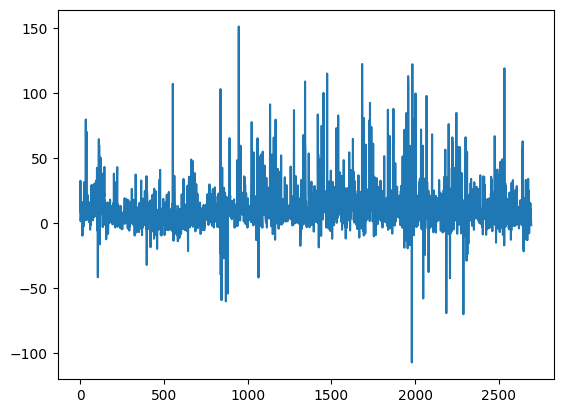

In [27]:
plt.plot(all_outputs)

In [28]:
count_bound = 0
count_no_bound = 0

within_bounds_outputs = []
within_bounds_truths = []

max_truth, min_truth = np.max(all_truths), np.min(all_truths)
print(f"Max Truth Val: {max_truth}")
print(f"Min Truth Val: {min_truth}")

for idx, pred in enumerate(all_outputs):
    if pred >= -1 and pred <= 1 and all_truths[idx] >= -1 and all_truths[idx] <= 1:
        count_bound += 1
        within_bounds_outputs.append(all_outputs[idx])
        within_bounds_truths.append(all_truths[idx])
    else:
        count_no_bound+=1

print(f"Within Bound -1 to 1: {count_bound}")
print(f"Outside of -1 to 1: {count_no_bound}")

Max Truth Val: 3.8637616634368896
Min Truth Val: -0.7724792957305908
Within Bound -1 to 1: 172
Outside of -1 to 1: 2523


C:\Users\lordw\AppData\Local\Temp\ipykernel_23664\522657886.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


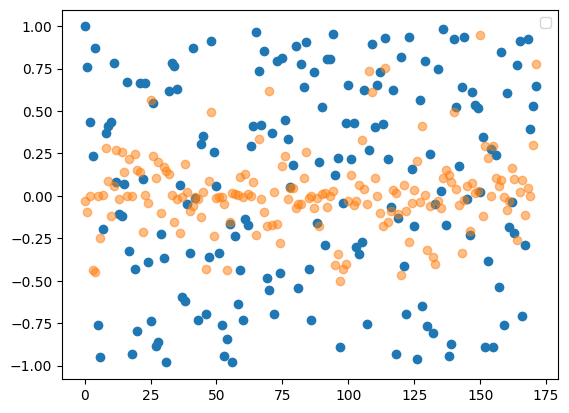

In [30]:
x = np.linspace(start=0, stop=len(within_bounds_outputs) - 1, num=len(within_bounds_outputs))

plt.scatter(x, within_bounds_outputs, alpha=1)
#plt.scatter(x, all_truths, alpha=0.05)
plt.scatter(x, within_bounds_truths, alpha=0.5)

plt.legend()